In [1]:
#Import packages

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pickle
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
import re
import random 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

In [2]:
#Function to get keys in the corresponding .p file
def print_all_keys(data, parent_key=""):
    """
    Recursively collects all keys in the .p file.

    :param data: The dictionary or list to traverse.
    :param parent_key: Used to build the key hierarchy for nested structures.
    :return: A list of all full keys.
    """
    full_keys = []  # Local list to store keys in this call

    if isinstance(data, dict):
        for key, value in data.items():
            full_key = f"{parent_key}.{key}" if parent_key else key
            full_keys.append(full_key)
            full_keys.extend(print_all_keys(value, full_key)) 
    elif isinstance(data, list):
        for index, item in enumerate(data):
            full_key = f"{parent_key}[{index}]" if parent_key else f"[{index}]"
            full_keys.append(full_key)  
            full_keys.extend(print_all_keys(item, full_key))  

    return full_keys

#Function to get value by specifying a particular key
def get_value(data, key_path):
    """
    Retrieve value from a nested dictionary based on a dot-separated key path.
    """
    keys = key_path.split(".")
    current_data = data
    for key in keys:
        if "[" in key and "]" in key:  # Handle list indices
            base_key, index = key.split("[")
            index = int(index[:-1])  # Convert '1]' to 1
            current_data = current_data.get(base_key, [])[index]
        else:
            current_data = current_data.get(key)
        if current_data is None:
            return None  # Return None if the key doesn't exist
    return current_data

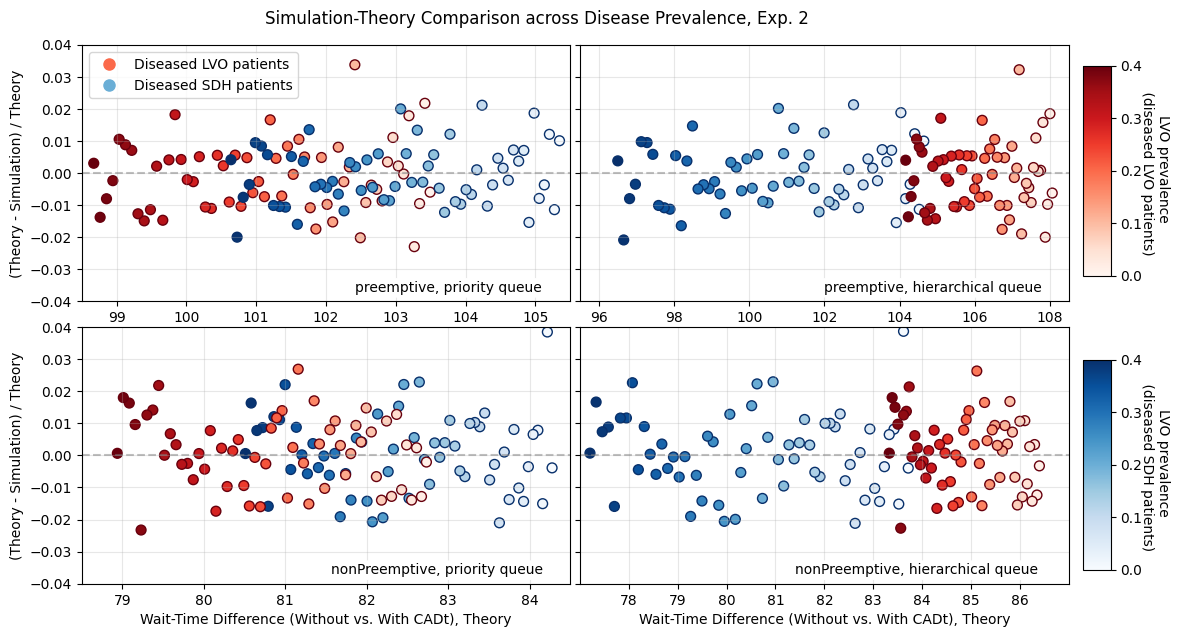

In [3]:
########################################################################
##### Experiment 2 -  disease probs
########################################################################

#Read file and get keys
file_path = 'BAoutputs/inputs/results_AILVOICH_2D_readTimeDiseaseProb.p'
with open(file_path, 'rb') as file:
    data = pickle.load(file)
full_keys = print_all_keys(data)

top_keys = []
for key in full_keys:
    segments = key.split('.')
    if len(segments) >= 4:
        top_key = '.'.join(segments[:4])  # Extract the first 4 segments
        top_keys.append(top_key)

top_keys = list(set(top_keys))  # Remove duplicates-------------------------------------------------

grouped_keys = {}
for top_key in top_keys:
    segments = top_key.split('.')
    preemptive_label = segments[1] #preemptive or nonPreemptive
    priority_hier_label = segments[2] #priority or hierarchical
    group_key = (preemptive_label, priority_hier_label)
    if group_key not in grouped_keys:
        grouped_keys[group_key] = []
    grouped_keys[group_key].append(top_key)

sorted_groups = sorted(grouped_keys.keys())
disease_labels = set()

#Get disease labels and make a color map dictionary corresponding to diseases
for group, keys_for_this_group in grouped_keys.items():
    for top_key in keys_for_this_group:
        segments = top_key.split('.')
        x_value_label = segments[0]  # e.g. 'diseaseProb'
        if x_value_label == 'diseaseProb':
            disease_label = segments[3]  # the final part
            disease_labels.add(disease_label)

disease_labels = sorted(disease_labels)  # for consistent order

color_map_dict = {}
color_map_list = [cm.Blues, cm.Reds, cm.Greens, cm.Purples, cm.Oranges]
for i, disease_label in enumerate(disease_labels):
    color_map_dict[disease_label] = color_map_list[i % len(color_map_list)]

# Initialize figure and set title.
# There are 4 sub-figures and we set the y-axis to be "shared" among figures in the same row as the values (theory-sim) will be similar
fig, axs = plt.subplots(2, 2, figsize=(14, 7), sharey = 'row')
fig.suptitle("Simulation-Theory Comparison across Disease Prevalence, Exp. 2", x=0.45, y=0.93)

# Make top/bottom and left/right plots closer together
fig.subplots_adjust(right=0.83, hspace=0.1, wspace=0.02)

# Custom positions
custom_positions = [
    (1, 1),  # group 0 - bottom right - nonPreemptive hierarchical
    (1, 0),  # group 1 - top right - nonPreemptive priority
    (0, 1),  # group 2 - bottom left - preemptive hierarchical
    (0, 0)   # group 3 - top left - preemptive priority
]

#Loop through each queueing scenario
for idx, group in enumerate(sorted_groups):
    row, col = custom_positions[idx]
    ax = axs[row, col]

    # Labels inside the plot for type of queueing scenario. Manually edit the position of each.
    preemptive_label, priority_hier_label = group
    title_text = f"{preemptive_label}, {priority_hier_label} queue"
    if idx == 0:
        ax.text(
            0.44, 0.08,             
            title_text,
            transform=ax.transAxes,
            ha='left',
            va='top',
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'),
        )
    if idx == 1:
        ax.text(
            0.51, 0.08,               
            title_text,
            transform=ax.transAxes,
            ha='left',
            va='top',
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'),
        )
    if idx == 2:
        ax.text(
            0.50, 0.08,               
            title_text,
            transform=ax.transAxes,
            ha='left',
            va='top',
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'),
        )
    if idx == 3:
        ax.text(
            0.56, 0.08,              
            title_text,
            transform=ax.transAxes,
            ha='left',
            va='top',
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'),
        )

    # Collect keys for this group and plot data
    keys_for_this_group = grouped_keys[group]
    for top_key in keys_for_this_group:
        segments = top_key.split('.')
        if segments[0] == 'diseaseProb':
            disease_label = segments[3]

            # Retrieve data
            queue_param = get_value(data, top_key + ".timeSaved.xvalue")
            simulated   = get_value(data, top_key + ".timeSaved.sim.mean")
            theoretical = get_value(data, top_key + ".timeSaved.theory.delta")

            # Index to pick the 30th column, fixing SDH prevalence at ~.2
            queue_param = queue_param[:, 30]
            simulated   = simulated[:, 30]
            theoretical = theoretical[:, 30]

            # Get edge color for each disease from its respective color palette
            norm = mcolors.Normalize(vmin=np.min(queue_param), vmax=np.max(queue_param))
            cmap = color_map_dict[disease_label]
            darkest_edge_color = cmap(1.0)

            #Scatter plot: represent wait-time-savings as a positive number by negating the theory value. 
            ax.scatter(
                -theoretical, 
                (-theoretical+simulated)/(-theoretical),
                c=queue_param,
                cmap=cmap,
                norm=norm,
                s=50,
                edgecolors=darkest_edge_color
            )

    if idx == 0: #NP hierarchical
        ax.set_xlim(77, 87)
        ax.set_xticks([78, 79, 80, 81, 82, 83, 84, 85, 86]) 
        ax.set_ylim(-0.04, 0.04)
        ax.grid(alpha=0.3)
        ax.axhline(y=0, color='gray', alpha=0.5, linestyle='--')
    if idx == 1: #NP priority
        ax.set_xlim(78.5, 84.5)
        ax.set_ylim(-0.04, 0.04)
        ax.grid(alpha=0.3)
        ax.axhline(y=0, color='gray', alpha=0.5, linestyle='--')
    if idx == 2: #preemptive hierarchical
        ax.set_xlim(95.5, 108.5)
        ax.set_ylim(-0.04, 0.04)
        ax.axhline(y=0, color='gray', alpha=0.5, linestyle='--')
        ax.grid(alpha=0.3)
    if idx == 3: #preemptive priority
        ax.set_xlim(98.5, 105.5)
        ax.set_ylim(-0.04, 0.04)
        ax.axhline(y=0, color='gray', alpha=0.5, linestyle='--')
        ax.grid(alpha=0.3)

    # Only the bottom row has an X-axis label
    if idx in [0, 1]:
        ax.set_xlabel('Wait-Time Difference (Without vs. With CADt), Theory')
    # Only the left column has a Y-axis label
    if col == 0:
        ax.set_ylabel('(Theory - Simulation) / Theory')

    # ---------------------------------------------------------------------
    # Create a legend in the FIRST subplot only
    # ---------------------------------------------------------------------
    if idx == 3:  # top-left subplot
        # Build custom handles for each disease
        handles = []
        for disease_label in disease_labels[::-1]:
            mid_color = color_map_dict[disease_label](0.5)
            if disease_label == 'ICH':
                disease_label = 'SDH'
            handle = mlines.Line2D(
                [], [],
                color=mid_color,
                marker='o',
                linestyle='None',
                markersize=8,
                label=f"Diseased {disease_label} patients"
            )
            handles.append(handle)

        # Place legend inside this subplot
        ax.legend(
            handles=handles,
            loc='upper left',
            bbox_to_anchor=(0.001, 0.999)
        )

# -------------------------------------------------------------------------
# Colorbars on the right - formatting
# -------------------------------------------------------------------------
colorbar_offset = 0.42
for i, disease_label in enumerate(disease_labels):
    cbar_ax = fig.add_axes([0.84, 0.55 - (1-i) * colorbar_offset, 0.02, 0.3])
    sm = cm.ScalarMappable(norm=norm,
                           cmap=color_map_dict[disease_label])
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cbar_ax)
    if disease_label == 'ICH':
        disease_label = 'SDH'
    cbar.set_label(f"LVO prevalence \n (diseased {disease_label} patients)", rotation=270, labelpad=20)

plt.show()


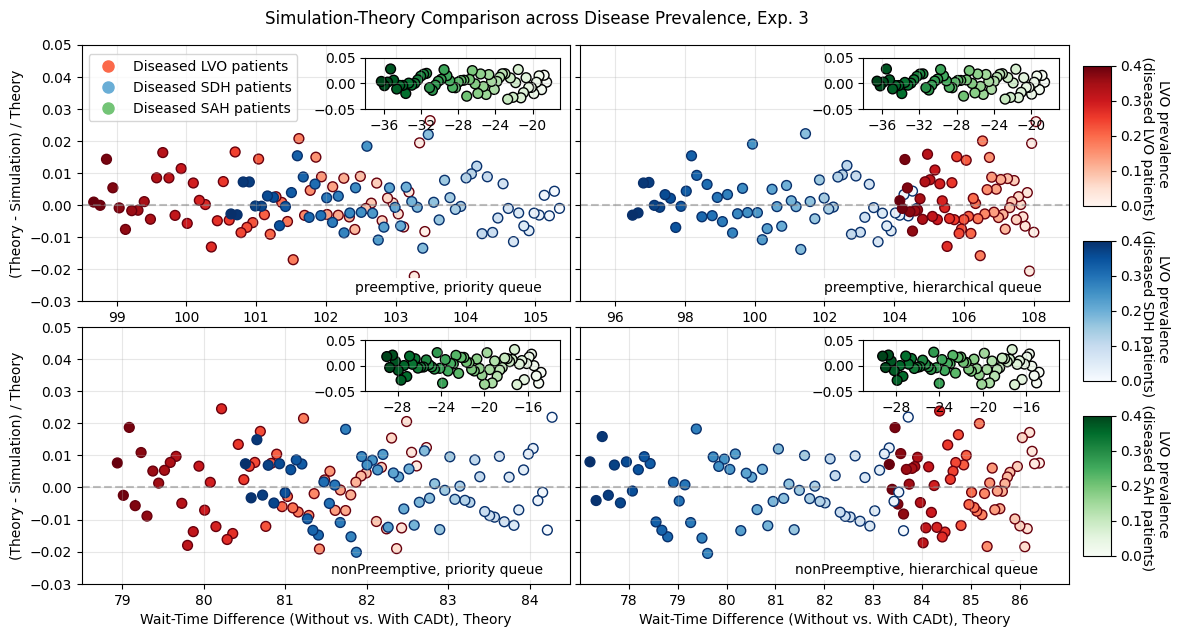

In [4]:
########################################################################
##### Experiment 3 -  disease probs
########################################################################

#Read .p file
file_path = 'BAoutputs/inputs/results_AILVOICHExp3_2D_diseaseProbsReadTimes.p'
with open(file_path, 'rb') as file:
    data = pickle.load(file)
    
full_keys = print_all_keys(data)

top_keys = []
for key in full_keys:
    segments = key.split('.')
    if len(segments) >= 4:  # Ensure it has at least 4 segments
        top_key = '.'.join(segments[:4])  # Extract the first 4 segments
        top_keys.append(top_key)

top_keys = list(set(top_keys))  # Remove duplicates-------------------------------------------------

grouped_keys = {}
for top_key in top_keys:
    segments = top_key.split('.')
    preemptive_label = segments[1]
    priority_hier_label = segments[2]
    group_key = (preemptive_label, priority_hier_label)
    if group_key not in grouped_keys:
        grouped_keys[group_key] = []
    grouped_keys[group_key].append(top_key)

sorted_groups = sorted(grouped_keys.keys())
disease_labels = set()

for group, keys_for_this_group in grouped_keys.items():
    for top_key in keys_for_this_group:
        segments = top_key.split('.')
        x_value_label = segments[0]  # e.g. 'diseaseProb'
        if x_value_label == 'diseaseProb':
            disease_label = segments[3] # e.g. 'LVO'
            disease_labels.add(disease_label)

disease_labels = sorted(disease_labels)

color_map_dict = {}
color_map_list = [cm.Blues, cm.Reds, cm.Greens, cm.Purples, cm.Oranges]
for i, disease_label in enumerate(disease_labels):
    color_map_dict[disease_label] = color_map_list[i % len(color_map_list)]

# Initialize figure and set title.
# There are 4 sub-figures and we set the y-axis to be "shared" among figures in the same row as the values (theory-sim) will be similar
fig, axs = plt.subplots(2, 2, figsize=(14, 7), sharey = 'row')
fig.suptitle("Simulation-Theory Comparison across Disease Prevalence, Exp. 3", x=0.45, y=0.93)

# Make top/bottom plots closer together
fig.subplots_adjust(right=0.83, hspace=0.1, wspace=0.02)

# Custom positions so that
#   idx=0 => top-left
#   idx=1 => bottom-left
#   idx=2 => top-right
#   idx=3 => bottom-right
custom_positions = [
    (1, 1),  # group 0 - nonPreemptive hierarchical
    (1, 0),  # group 1 - nonPreemptive priority
    (0, 1),  # group 2 - preemptive hierarchical
    (0, 0)   # group 3 - preemptive priority
]

for idx, group in enumerate(sorted_groups):
    row, col = custom_positions[idx]
    ax = axs[row, col]

    # Titles INSIDE the plot
    preemptive_label, priority_hier_label = group
    title_text = f"{preemptive_label}, {priority_hier_label} queue"
    if idx == 0:
        ax.text(
            0.44, 0.08,
            title_text,
            transform=ax.transAxes,
            ha='left',
            va='top',
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'),
        )
    if idx == 1:
        ax.text(
            0.51, 0.08,
            title_text,
            transform=ax.transAxes,
            ha='left',
            va='top',
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'),
        )
    if idx == 2:
        ax.text(
            0.50, 0.08,
            title_text,
            transform=ax.transAxes,
            ha='left',
            va='top',
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'),
        )
    if idx == 3:
        ax.text(
            0.56, 0.08,
            title_text,
            transform=ax.transAxes,
            ha='left',
            va='top',
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'),
        )

    # Collect keys for this group and plot data
    keys_for_this_group = grouped_keys[group]
    for top_key in keys_for_this_group:
        segments = top_key.split('.')
        if segments[0] == 'diseaseProb':
            disease_label = segments[3]

            # Retrieve data
            queue_param = get_value(data, top_key + ".timeSaved.xvalue")
            simulated   = get_value(data, top_key + ".timeSaved.sim.mean")
            theoretical = get_value(data, top_key + ".timeSaved.theory.delta")

            # Index to pick the 30th column, fixing SDH prevalence at ~.2
            queue_param = queue_param[:, 30]
            simulated   = simulated[:, 30]
            theoretical = theoretical[:, 30]

            # Get edge color for each disease from its respective color palette
            norm = mcolors.Normalize(vmin=np.min(queue_param), vmax=np.max(queue_param))
            cmap = color_map_dict[disease_label]
            darkest_edge_color = cmap(1.0)

            ax.scatter(
                -theoretical, 
                (-theoretical+simulated)/(-theoretical),
                c=queue_param,
                cmap=cmap,
                norm=norm,
                s=50,
                edgecolors=darkest_edge_color
            )

            #Inset plot for third disease
            if disease_label == "SAH":
                # Create an inset axis at position [x0, y0, width, height] in axes-relative coordinates
                # (0,0) is bottom-left, (1,1) is top-right of the parent axis.
                axins = ax.inset_axes([0.58, 0.75, 0.4, 0.2])  # tweak these numbers
            
                # Plot data in the inset
                axins.scatter(
                    -theoretical,
                    (-theoretical+simulated)/(-theoretical),
                    c=queue_param,       # same color logic
                    cmap=color_map_dict[disease_label],
                    norm=norm,
                    s=50,
                    edgecolors='k'
                )
            
                # Set the limits for the inset
                if idx == 2 or idx == 3:
                    axins.set_xlim(-38, -17)
                    axins.set_ylim(-0.05, 0.05)
                    axins.set_xticks([-36, -32, -28, -24, -20])
                    axins.grid(alpha=0.3)
                else:
                    axins.set_xlim(-31, -13)
                    axins.set_ylim(-0.05, 0.05)
                    axins.set_xticks([-28, -24, -20, -16])
                    axins.grid(alpha=0.3)

    #Set limits, ticks manually
    if idx == 0: #NP hier
        ax.set_xlim(77, 87)
        ax.set_xticks([78, 79, 80, 81, 82, 83, 84, 85, 86])
        ax.set_ylim(-0.03, 0.05)
        ax.grid(alpha=0.3)
        ax.axhline(y=0, color='gray', alpha=0.5, linestyle='--')
    if idx == 1: #NP priority
        ax.set_xlim(78.5, 84.5)
        ax.set_ylim(-0.03, 0.05)
        ax.grid(alpha=0.3)
        ax.axhline(y=0, color='gray', alpha=0.5, linestyle='--')
    if idx == 2: #preemptive hierarchical
        ax.set_xlim(95, 109)
        ax.set_ylim(-0.03, 0.05)
        ax.axhline(y=0, color='gray', alpha=0.5, linestyle='--')
        ax.grid(alpha=0.3)
    if idx == 3: #preemptive priority
        ax.set_xlim(98.5, 105.5)
        ax.set_ylim(-0.03, 0.05)
        ax.axhline(y=0, color='gray', alpha=0.5, linestyle='--')
        ax.grid(alpha=0.3)

    # Only the bottom row has an X-axis label
    if idx in [0, 1]:
        ax.set_xlabel('Wait-Time Difference (Without vs. With CADt), Theory')
    # Only the left column has a Y-axis label
    if col == 0:
        ax.set_ylabel('(Theory - Simulation) / Theory')

    # ---------------------------------------------------------------------
    # Create a legend in the FIRST subplot only
    # ---------------------------------------------------------------------
    if idx == 3:  # top-left subplot
        # Build custom handles for each disease
        handles = []
        for disease_label in ['LVO', 'ICH', 'SAH']:
            mid_color = color_map_dict[disease_label](0.5)
            if disease_label == 'ICH':
                disease_label = 'SDH'
            handle = mlines.Line2D(
                [], [],
                color=mid_color,
                marker='o',
                linestyle='None',
                markersize=8,
                label=f"Diseased {disease_label} patients"
            )
            handles.append(handle)

        # Place legend inside this subplot
        ax.legend(
            handles=handles,
            loc='upper left',
            bbox_to_anchor=(0, 0.99)
        )

# -------------------------------------------------------------------------
# Keep colorbars on the right
# -------------------------------------------------------------------------
colorbar_offset = 0.25
for i, disease_label in enumerate(disease_labels):
    cbar_ax = fig.add_axes([0.84, 0.65 - (1.5*i**2 - 2.5*i + 1) * colorbar_offset, 0.02, 0.2])
    sm = cm.ScalarMappable(norm=norm,
                           cmap=color_map_dict[disease_label])
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cbar_ax)
    if disease_label == 'ICH':
        disease_label = 'SDH'
    cbar.set_label(f"LVO prevalence \n (diseased {disease_label} patients)", rotation=270, labelpad=20)

plt.show()


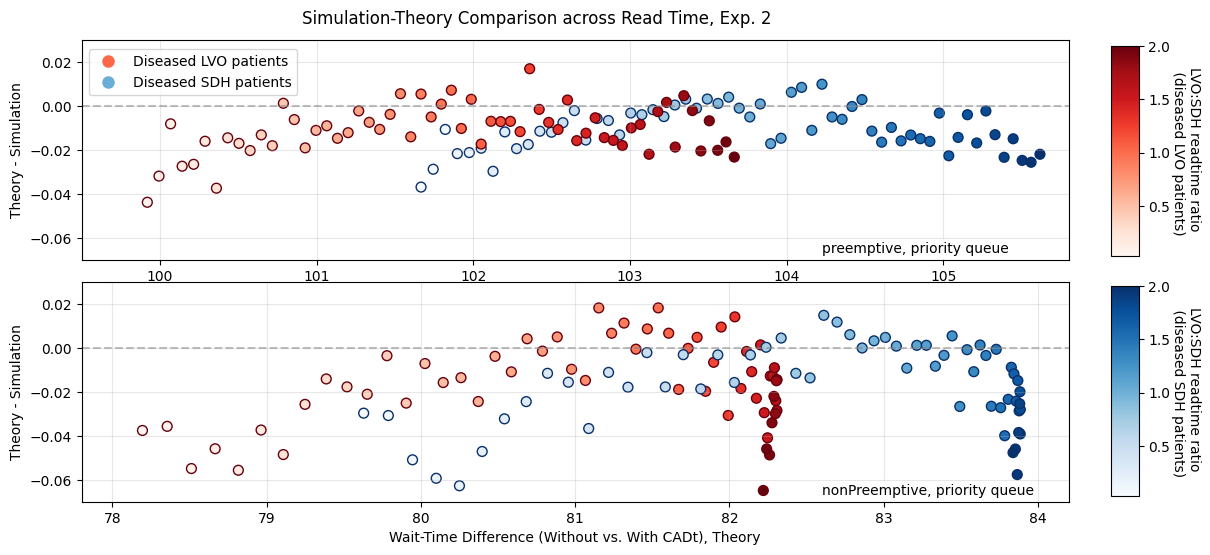

In [5]:
########################################################################
##### Experiment 2 - read Times
########################################################################

file_path = 'BAoutputs/inputs/results_AILVOICH_2D_readTimeDiseaseProb.p'
with open(file_path, 'rb') as file:
    data = pickle.load(file)

full_keys = print_all_keys(data)

top_keys = []
for key in full_keys:
    segments = key.split('.')
    if len(segments) >= 4:  # Ensure it has at least 4 segments
        top_key = '.'.join(segments[:4])  # Extract the first 4 segments
        top_keys.append(top_key)

top_keys = list(set(top_keys))  # Remove duplicates-------------------------------------------------

grouped_keys = {}
for top_key in top_keys:
    segments = top_key.split('.')
    preemptive_label = segments[1]
    priority_hier_label = segments[2]
    group_key = (preemptive_label, priority_hier_label)
    if group_key not in grouped_keys:
        grouped_keys[group_key] = []
    grouped_keys[group_key].append(top_key)

sorted_groups = sorted(grouped_keys.keys())
disease_labels = set()

for group, keys_for_this_group in grouped_keys.items():
    for top_key in keys_for_this_group:
        segments = top_key.split('.')
        x_value_label = segments[0]  # e.g. 'readTime'
        if x_value_label == 'readTime':
            disease_label = segments[3]  # e.g. 'LVO'
            disease_labels.add(disease_label)

            # Extract the queue_param array
            queue_param = get_value(data, top_key + ".timeSaved.xvalue")

disease_labels = sorted(disease_labels)  # for consistent order

color_map_dict = {}
color_map_list = [cm.Blues, cm.Reds, cm.Greens, cm.Purples, cm.Oranges]
for i, disease_label in enumerate(disease_labels):
    color_map_dict[disease_label] = color_map_list[i % len(color_map_list)]

#Initialize figure. We only have one row for the priority case, 
#as multi-QuCAD does not return theoretical estimates in the hierarchical case for different read-times.
fig, axs = plt.subplots(2, 1, figsize=(14, 6), sharex='row')
fig.suptitle("Simulation-Theory Comparison across Read Time, Exp. 2", x=0.45, y=0.93)

# Make top/bottom plots closer together
fig.subplots_adjust(right=0.83, hspace=0.1)

# Custom positions so that
#   idx=0 => top-left
#   idx=1 => bottom-left
#   idx=2 => top-right
#   idx=3 => bottom-right
custom_positions = [
    (1, 1),  # group 0 - nonPreemptive hierarchical
    (1, 0),  # group 1 - nonPreemptive priority
    (0, 1),  # group 2 - preemptive hierarchical
    (0, 0)   # group 3 - preemptive priority
]

for idx, group in enumerate(sorted_groups):
    row, col = custom_positions[idx]
    ax = axs[row]

    # Titles INSIDE the plot
    preemptive_label, priority_hier_label = group
    title_text = f"{preemptive_label}, {priority_hier_label} queue"
    if idx == 1:
        ax.text(
            0.75, 0.08,
            title_text,
            transform=ax.transAxes,
            ha='left',
            va='top',
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'),
        )
    if idx == 3:
        ax.text(
            0.75, 0.08,
            title_text,
            transform=ax.transAxes,
            ha='left',
            va='top',
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'),
        )

    # Collect keys for this group and plot data
    keys_for_this_group = grouped_keys[group]
    for top_key in keys_for_this_group:
        segments = top_key.split('.')
        if segments[0] == 'readTime':
            disease_label = segments[3]

            # Retrieve data
            queue_param = get_value(data, top_key + ".timeSaved.xvalue")
            simulated   = get_value(data, top_key + ".timeSaved.sim.mean")
            theoretical = get_value(data, top_key + ".timeSaved.theory.delta")

            # Index to pick 30th column, fixing SDH read-Time at 30 minutes
            queue_param = queue_param[:, 29]
            queue_param = queue_param/30
            simulated   = simulated[:, 29]
            theoretical = theoretical[:, 29]

            #color for
            norm = mcolors.Normalize(vmin=np.min(queue_param), vmax=np.max(queue_param))
            cmap = color_map_dict[disease_label]
            darkest_edge_color = cmap(1.0)

            #Plot theory vs sim
            if idx == 1 or idx == 3:
                ax.scatter(
                    -theoretical,
                    (-theoretical+simulated)/(-theoretical), 
                    c=queue_param,
                    cmap=cmap,
                    norm=norm,
                    s=50,
                    edgecolors=darkest_edge_color
                )

            #Inset plots for third disease
            if disease_label == "SAH" and (idx == 1 or idx == 3):
                # Create an inset axis at position [x0, y0, width, height] in axes-relative coordinates
                # (0,0) is bottom-left, (1,1) is top-right of the parent axis.
                axins = ax.inset_axes([0.775, 0.76, 0.22, 0.22])  # tweak these numbers

                #Plot data
                axins.scatter(
                    theoretical,
                    theoretical-simulated,
                    c=queue_param,       # same color logic
                    cmap=color_map_dict[disease_label],
                    norm=norm,
                    s=50,
                    edgecolors='k'
                )
            
                # Set the limits for the inset
                if idx == 3:
                    axins.set_xlim(-33, -17)
                    axins.set_ylim(-1.5, 1.5)
                    axins.set_xticks([-32, -28, -24, -20])
                    axins.set_yticks([-1, 0, 1])
                    axins.axhline(y=0, color='gray', alpha=0.5, linestyle='--')
                    axins.grid(alpha=0.3)
                elif idx == 1:
                    axins.set_xlim(-31, -13)
                    axins.set_ylim(-5, 1.5)
                    axins.set_xticks([-28, -24, -20, -16])
                    axins.set_yticks([-4, -2, 0])
                    axins.axhline(y=0, color='gray', alpha=0.5, linestyle='--')
                    axins.grid(alpha=0.3)

    if idx == 3:
        ax.set_xlim(99.5, 105.8)
        ax.set_ylim(-0.07, 0.03)
        ax.set_xticks([100, 101, 102, 103, 104, 105])
        ax.grid(alpha=0.3)
        ax.axhline(y=0, color = 'gray', alpha = 0.5, linestyle = "--")
    if idx == 1:
        ax.set_xlim(77.8, 84.2)
        ax.set_ylim(-0.07, 0.03)
        ax.set_xticks([78, 79, 80, 81, 82, 83, 84])
        ax.grid(alpha=0.3)
        ax.axhline(y=0, color = 'gray', alpha = 0.5, linestyle = "--")

    # Only the bottom row has an X-axis label
    if idx in [0, 1]:
        ax.set_xlabel('Wait-Time Difference (Without vs. With CADt), Theory')
    # Only the left column has a Y-axis label
    if col == 0:
        ax.set_ylabel('Theory - Simulation')

    # ---------------------------------------------------------------------
    # Create a legend in the FIRST subplot only
    # ---------------------------------------------------------------------
    if idx == 3:  # top-left subplot
        # Build custom handles for each disease
        handles = []
        for disease_label in ['LVO', 'ICH']:
            mid_color = color_map_dict[disease_label](0.5)
            if disease_label == 'ICH':
                disease_label = 'SDH'
            handle = mlines.Line2D(
                [], [],
                color=mid_color,
                marker='o',
                linestyle='None',
                markersize=8,
                label=f"Diseased {disease_label} patients"
            )
            handles.append(handle)

        # Place legend inside this subplot
        ax.legend(
            handles=handles,
            loc='upper left',
            bbox_to_anchor=(0, 0.99)
        )

# -------------------------------------------------------------------------
# Keep colorbars on the right
# -------------------------------------------------------------------------

colorbar_offset = 0.4
for i, disease_label in enumerate(disease_labels):
    cbar_ax = fig.add_axes([0.86, 0.52 - (1.5*i**2 - 2.5*i + 1) * colorbar_offset, 0.02, 0.35])
    sm = cm.ScalarMappable(norm=norm,
                           cmap=color_map_dict[disease_label])
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cbar_ax)
    if disease_label == 'ICH':
        disease_label = 'SDH'
    cbar.set_label(f"LVO:SDH readtime ratio \n (diseased {disease_label} patients)", rotation=270, labelpad=22)

plt.show()


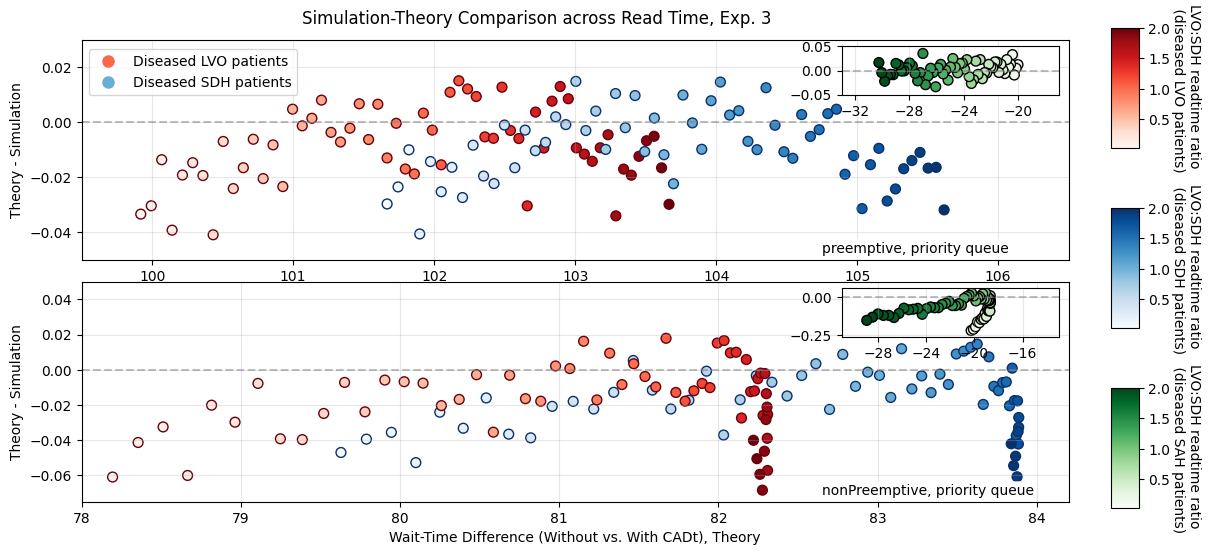

In [6]:
########################################################################
##### Experiment 3 - read Times
########################################################################

#Read .p file
file_path = 'BAoutputs/inputs/results_AILVOICHExp3_2D_diseaseProbsReadTimes.p'
with open(file_path, 'rb') as file:
    data = pickle.load(file)

full_keys = print_all_keys(data)

top_keys = []
for key in full_keys:
    segments = key.split('.')
    if len(segments) >= 4:  # Ensure it has at least 4 segments
        top_key = '.'.join(segments[:4])  # Extract the first 4 segments
        top_keys.append(top_key)

top_keys = list(set(top_keys))  # Remove duplicates-------------------------------------------------

grouped_keys = {}
for top_key in top_keys:
    segments = top_key.split('.')
    preemptive_label = segments[1]
    priority_hier_label = segments[2]
    group_key = (preemptive_label, priority_hier_label)
    if group_key not in grouped_keys:
        grouped_keys[group_key] = []
    grouped_keys[group_key].append(top_key)

sorted_groups = sorted(grouped_keys.keys())

disease_labels = set()

for group, keys_for_this_group in grouped_keys.items():
    for top_key in keys_for_this_group:
        segments = top_key.split('.')
        x_value_label = segments[0]  # e.g. 'readTime'
        if x_value_label == 'readTime':
            disease_label = segments[3]  # e.g. 'LVO'
            disease_labels.add(disease_label)
            # Extract the queue_param array
            queue_param = get_value(data, top_key + ".timeSaved.xvalue")


disease_labels = sorted(disease_labels)

#Color map dictionary
color_map_dict = {}
color_map_list = [cm.Blues, cm.Reds, cm.Greens, cm.Purples, cm.Oranges]
for i, disease_label in enumerate(disease_labels):
    color_map_dict[disease_label] = color_map_list[i % len(color_map_list)]

#Initialize figure. Again here we will only plot one row for priority queue, leaving out hierarchical.
fig, axs = plt.subplots(2, 1, figsize=(14, 6), sharex='row')
fig.suptitle("Simulation-Theory Comparison across Read Time, Exp. 3", x=0.45, y=0.93)

# Make top/bottom plots closer together
fig.subplots_adjust(right=0.83, hspace=0.1)

# Custom positions so that
#   idx=0 => top-left
#   idx=1 => bottom-left
#   idx=2 => top-right
#   idx=3 => bottom-right
custom_positions = [
    (1, 1),  # group 0 - nonPreemptive hierarchical
    (1, 0),  # group 1 - nonPreemptive priority
    (0, 1),  # group 2 - preemptive hierarchical
    (0, 0)   # group 3 - preemptive priority
]

for idx, group in enumerate(sorted_groups):
    row, col = custom_positions[idx]
    ax = axs[row]

    # Titles INSIDE the plot
    preemptive_label, priority_hier_label = group
    title_text = f"{preemptive_label}, {priority_hier_label} queue"
    if idx == 1:
        ax.text(
            0.75, 0.08,  
            title_text,
            transform=ax.transAxes,
            ha='left',
            va='top',
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'),
        )
    if idx == 3:
        ax.text(
            0.75, 0.08,
            title_text,
            transform=ax.transAxes,
            ha='left',
            va='top',
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'),
        )

    # Collect keys for this group and plot data
    keys_for_this_group = grouped_keys[group]
    for top_key in keys_for_this_group:
        segments = top_key.split('.')
        if segments[0] == 'readTime':
            disease_label = segments[3]

            # Retrieve data (example: pick 30th column)
            queue_param = get_value(data, top_key + ".timeSaved.xvalue")
            simulated = get_value(data, top_key + ".timeSaved.sim.mean")
            theoretical = get_value(data, top_key + ".timeSaved.theory.delta")

            # Index to pick the 30th column, fixing LVO (SDH?) prevalence at .2
            queue_param = queue_param[:, 29]
            queue_param = queue_param/30
            simulated = simulated[:, 29]
            theoretical = theoretical[:, 29]

            #Color map
            norm = mcolors.Normalize(vmin=np.min(queue_param), vmax=np.max(queue_param))
            cmap = color_map_dict[disease_label]
            darkest_edge_color = cmap(1.0)

            if idx == 1 or idx == 3:
                ax.scatter(
                    -theoretical,
                    (-theoretical+simulated)/(-theoretical), 
                    c=queue_param,
                    cmap=cmap,
                    norm=norm,
                    s=50,
                    edgecolors=darkest_edge_color
                )

            #Inset for third disease
            if disease_label == "SAH" and (idx == 1 or idx == 3):
                # Create an inset axis at position [x0, y0, width, height] in axes-relative coordinates
                # (0,0) is bottom-left, (1,1) is top-right of the parent axis.
                axins = ax.inset_axes([0.77, 0.75, 0.22, 0.22])  # tweak these numbers
            
                axins.scatter(
                    -theoretical,
                    (-theoretical+simulated)/(theoretical),
                    c=queue_param,       # same color logic
                    cmap=color_map_dict[disease_label],
                    norm=norm,
                    s=50,
                    edgecolors='k'
                )
            
                # Set the limits for the inset
                if idx == 3:
                    axins.set_xlim(-33, -17)
                    axins.set_ylim(-0.05, 0.05)
                    axins.set_xticks([-32, -28, -24, -20])
                    axins.axhline(y=0, color='gray', alpha=0.5, linestyle='--')
                    axins.grid(alpha=0.3)
                elif idx == 1:
                    axins.set_xlim(-31, -13)
                    axins.set_ylim(-0.26, 0.06)
                    axins.set_xticks([-28, -24, -20, -16])
                    axins.axhline(y=0, color='gray', alpha=0.5, linestyle='--')
                    axins.grid(alpha=0.3)

    if idx == 3:
        ax.set_xlim(99.5, 106.5)
        ax.set_ylim(-0.05, 0.03)
        ax.set_xticks([100, 101, 102, 103, 104, 105, 106])
        ax.grid(alpha=0.3)
        ax.axhline(y=0, color = 'gray', alpha = 0.5, linestyle = "--")
    if idx == 1:
        ax.set_xlim(78.2, 84.2)
        ax.set_ylim(-0.075, 0.05)
        ax.set_xticks([78, 79, 80, 81, 82, 83, 84])
        ax.grid(alpha=0.3)
        ax.axhline(y=0, color = 'gray', alpha = 0.5, linestyle = "--")

    # Only the bottom row has an X-axis label
    if idx in [0, 1]:
        ax.set_xlabel('Wait-Time Difference (Without vs. With CADt), Theory')
    # Only the left column has a Y-axis label
    if col == 0:
        ax.set_ylabel('Theory - Simulation')

    # ---------------------------------------------------------------------
    # Create a legend in the FIRST subplot only
    # ---------------------------------------------------------------------
    if idx == 3:  # top-left subplot
        # Build custom handles for each disease
        handles = []
        for disease_label in ['LVO', 'ICH']:
            mid_color = color_map_dict[disease_label](0.5)
            if disease_label == 'ICH':
                disease_label = 'SDH'
            handle = mlines.Line2D(
                [], [],
                color=mid_color,
                marker='o',
                linestyle='None',
                markersize=8,
                label=f"Diseased {disease_label} patients"
            )
            handles.append(handle)

        # Place legend inside this subplot
        ax.legend(
            handles=handles,
            loc='upper left',
            bbox_to_anchor=(0, 0.99)
        )

# -------------------------------------------------------------------------
# Keep colorbars on the right
# -------------------------------------------------------------------------

colorbar_offset = 0.3
for i, disease_label in enumerate(disease_labels):
    cbar_ax = fig.add_axes([0.86, 0.7 - (1.5*i**2 - 2.5*i + 1) * colorbar_offset, 0.02, 0.2])
    sm = cm.ScalarMappable(norm=norm,
                           cmap=color_map_dict[disease_label])
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cbar_ax)
    if disease_label == 'ICH':
        disease_label = 'SDH'
    cbar.set_label(f"LVO:SDH readtime ratio \n (diseased {disease_label} patients)", rotation=270, labelpad=22)

plt.show()


['ICH', 'LVO']
{'ICH': <matplotlib.colors.LinearSegmentedColormap object at 0x000001C526FAC9B0>, 'LVO': <matplotlib.colors.LinearSegmentedColormap object at 0x000001C526FACDD0>}


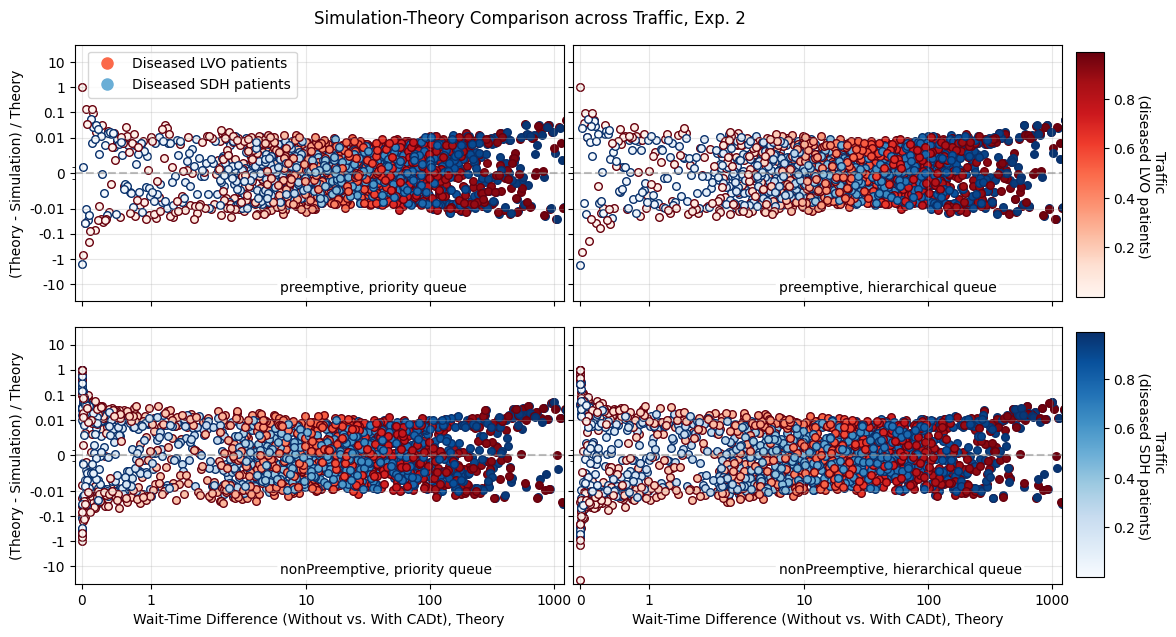

In [8]:
########################################################################
##### Experiment 2 - traffics
##### Note: traffics take a while to plot because of the "random shuffling" to avoid overlap of blue and red points. This can be removed if needed.
########################################################################

from brokenaxes import brokenaxes 

#Read .p file
file_path = 'BAoutputs/inputs/results_AILVOICH_1D.p'
with open(file_path, 'rb') as file:
    data = pickle.load(file)

full_keys = print_all_keys(data)

top_keys = []
for key in full_keys:
    segments = key.split('.')
    if len(segments) >= 4:  # Ensure it has at least 4 segments
        top_key = '.'.join(segments[:4])  # Extract the first 4 segments
        top_keys.append(top_key)

top_keys = list(set(top_keys))  # Remove duplicates-------------------------------------------------

grouped_keys = {}
for top_key in top_keys:
    segments = top_key.split('.')
    preemptive_label = segments[1]
    priority_hier_label = segments[2]
    group_key = (preemptive_label, priority_hier_label)
    if group_key not in grouped_keys:
        grouped_keys[group_key] = []
    grouped_keys[group_key].append(top_key)

disease_labels = set()
# We'll store all queue_params in a dict keyed by disease_label
all_queue_params = {}

for group, keys_for_this_group in grouped_keys.items():
    for top_key in keys_for_this_group:
        segments = top_key.split('.')
        x_value_label = segments[0]  # e.g. 'diseaseProb'
        if x_value_label == 'traffics':
            disease_label = segments[3]  # the final part
            disease_labels.add(disease_label)

            # Extract the queue_param array
            queue_param = get_value(data, top_key + ".timeSaved.xvalue")
            if queue_param is not None:
                # Just an example, picking the 30th column:
                queue_param_1d = queue_param
                # Collect
                if disease_label not in all_queue_params:
                    all_queue_params[disease_label] = []
                all_queue_params[disease_label].append(queue_param_1d)

disease_labels = sorted(disease_labels)  # for consistent order
print(disease_labels)

color_map_dict = {}
color_map_list = [cm.Blues, cm.Reds, cm.Greens, cm.Purples, cm.Oranges]
for i, disease_label in enumerate(disease_labels):
    color_map_dict[disease_label] = color_map_list[i % len(color_map_list)]

print(color_map_dict)

#Initialize figure
fig, axs = plt.subplots(2, 2, figsize=(14, 7), sharex='col', sharey='row')
fig.suptitle("Simulation-Theory Comparison across Traffic, Exp. 2", x=0.45, y=0.93)

# Make top/bottom plots closer together
fig.subplots_adjust(right=0.83, hspace=0.1, wspace = 0.02)

# Custom positions so that
#   idx=0 => top-left
#   idx=1 => bottom-left
#   idx=2 => top-right
#   idx=3 => bottom-right
custom_positions = [
    (1, 1),  # group 0 - nonPreemptive hierarchical
    (1, 0),  # group 1 - nonPreemptive priority
    (0, 1),  # group 2 - preemptive hierarchical
    (0, 0)   # group 3 - preemptive priority
]

for idx, group in enumerate(sorted_groups):
    row, col = custom_positions[idx]
    ax = axs[row, col]

    # Titles INSIDE the plot
    preemptive_label, priority_hier_label = group
    title_text = f"{preemptive_label}, {priority_hier_label} queue"
    if idx == 0:
        ax.text(
            0.42, 0.08,      
            title_text,
            transform=ax.transAxes,
            ha='left',
            va='top',
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'),
        )
    if idx == 1:
        ax.text(
            0.42, 0.08,     
            title_text,
            transform=ax.transAxes,
            ha='left',
            va='top',
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'),
        )
    if idx == 2:
        ax.text(
            0.42, 0.08,       
            title_text,
            transform=ax.transAxes,
            ha='left',
            va='top',
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'),
        )
    if idx == 3:
        ax.text(
            0.42, 0.08,   
            title_text,
            transform=ax.transAxes,
            ha='left',
            va='top',
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'),
        )

    # Collect keys for this group and plot data
    keys_for_this_group = grouped_keys[group]
    all_points = []
    for top_key in keys_for_this_group:
        segments = top_key.split('.')
        if segments[0] == 'traffics':
            disease_label = segments[3]

            # Retrieve data
            queue_param = get_value(data, top_key + ".timeSaved.xvalue")
            if disease_label == 'LVO':
                simulated   = get_value(data, top_key + ".timeSaved.sim.mean")
                theoretical = get_value(data, top_key + ".timeSaved.theory.delta")
                x_vals = -theoretical
                y_vals = (-theoretical+simulated)/(-theoretical)
            elif disease_label == 'ICH':
                simulated   = get_value(data, top_key + ".timeSaved.sim.mean")
                theoretical = get_value(data, top_key + ".timeSaved.theory.delta")
                x_vals = -theoretical
                y_vals = (-theoretical+simulated)/(-theoretical)
                
            for x, y, cval in zip(x_vals, y_vals, queue_param):
                all_points.append((x, y, cval, disease_label))

            norm = mcolors.Normalize(vmin=np.min(queue_param), vmax=np.max(queue_param))

            # Plot
            cmap = color_map_dict[disease_label]
            darkest_edge_color = cmap(1.0)

    random.shuffle(all_points)
    for i, (x, y, cval, disease_label) in enumerate(all_points):
        # Map color for that disease
        cmap = color_map_dict[disease_label]
        darkest_edge_color = cmap(1.0)
        
        color = cmap(norm(cval))
    
        ax.scatter(
            [x], [y],
            c=[color],     # single color
            s=30,
            edgecolor=darkest_edge_color,
        )


    if idx == 1 or idx == 3:
        ax.set_xlim(-0.1, 1200)
        ax.grid(alpha=0.3)
        ax.set_xscale("symlog")
        ax.set_yscale('symlog', linthresh=0.005)  #set log scale for y axis, linthresh sets where the 'linear' region around 0 is
        ax.set_ylabel('(Theory - Simulation) / Theory')
        yticks = [-10, -1, -0.1, -0.01, 0, 0.01, 0.1, 1, 10]
        ax.set_yticks(yticks)
        labels = [f"{val}" for val in yticks]
        ax.set_yticklabels(labels)
        ax.set_ylim(-50, 50)
    else:
        ax.set_xscale("symlog")
        ax.set_xlim(-0.1, 1200)
        ax.grid(alpha=0.3)
        ax.set_ylim(-50, 50)

    if idx == 1 or idx == 0:
        ax.set_xlabel('Wait-Time Difference (Without vs. With CADt), Theory')

    ax.axhline(y=0, color = 'gray', alpha = 0.5, linestyle = '--')

    for row in axs:
        for ax in row:
            ax.set_xticks([0, 1, 10, 100, 1000])
            x_ticks = [0, 1, 10, 100, 1000]
            x_labels = [f"{val:.0f}" for val in x_ticks]   # e.g. -1, -10, -100
            ax.set_xticklabels(x_labels)
        
    # ---------------------------------------------------------------------
    # Create a legend in the FIRST subplot only
    # ---------------------------------------------------------------------
    handles = []
    for disease_label in ['LVO', 'ICH']:
        mid_color = color_map_dict[disease_label](0.5)
        if disease_label == 'ICH':
            disease_label = 'SDH'
        handle = mlines.Line2D(
            [], [],
            color=mid_color,
            marker='o',
            linestyle='None',
            markersize=8,
            label=f"Diseased {disease_label} patients"
        )
        handles.append(handle)

        # Place legend inside this subplot
    ax.legend(
            handles=handles,
            loc='upper center',
        bbox_to_anchor = (-.78, 2.1)
    )

# -------------------------------------------------------------------------
# Keep colorbars on the right
# -------------------------------------------------------------------------

colorbar_offset = 0.4
for i, disease_label in enumerate(disease_labels):
    cbar_ax = fig.add_axes([0.84, 0.52 - (3/2*i**2 - 5/2*i +1) * colorbar_offset, 0.02, 0.35])
    sm = cm.ScalarMappable(norm=norm,
                           cmap=color_map_dict[disease_label])
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cbar_ax)
    if disease_label == 'ICH':
        disease_label = 'SDH'
    cbar.set_label(f"Traffic \n (diseased {disease_label} patients)", rotation=270, labelpad=22)

plt.show()


{'ICH': <matplotlib.colors.LinearSegmentedColormap object at 0x00000136CDE90980>, 'LVO': <matplotlib.colors.LinearSegmentedColormap object at 0x00000136CDE90DA0>, 'SAH': <matplotlib.colors.LinearSegmentedColormap object at 0x00000136CDE90AA0>}


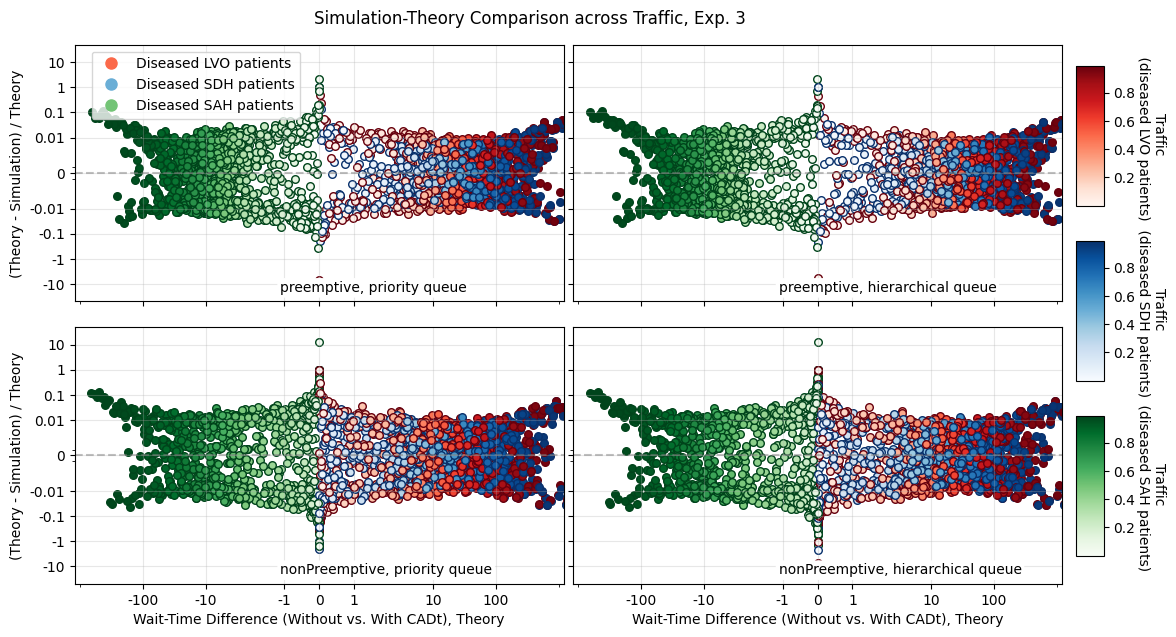

In [81]:
#Exp 3 - traffics

#Read .p file
file_path = 'BAoutputs/inputs/results_AILVOICHExp3_1D_traffics.p'
with open(file_path, 'rb') as file:
    data = pickle.load(file)

full_keys = print_all_keys(data)

top_keys = []
for key in full_keys:
    segments = key.split('.')
    if len(segments) >= 4:  # Ensure it has at least 4 segments
        top_key = '.'.join(segments[:4])  # Extract the first 4 segments
        top_keys.append(top_key)

top_keys = list(set(top_keys))  # Remove duplicates-------------------------------------------------

grouped_keys = {}
for top_key in top_keys:
    segments = top_key.split('.')
    preemptive_label = segments[1]
    priority_hier_label = segments[2]
    group_key = (preemptive_label, priority_hier_label)
    if group_key not in grouped_keys:
        grouped_keys[group_key] = []
    grouped_keys[group_key].append(top_key)

# Sort your groups so you have a consistent order
sorted_groups = sorted(grouped_keys.keys())

disease_labels = set()

for group, keys_for_this_group in grouped_keys.items():
    for top_key in keys_for_this_group:
        segments = top_key.split('.')
        x_value_label = segments[0]  # e.g. 'diseaseProb'
        if x_value_label == 'traffics':
            disease_label = segments[3]  # the final part
            disease_labels.add(disease_label)

            # Extract the queue_param array
            queue_param = get_value(data, top_key + ".timeSaved.xvalue")

disease_labels = sorted(disease_labels)  # for consistent order

color_map_dict = {}
color_map_list = [cm.Blues, cm.Reds, cm.Greens, cm.Purples, cm.Oranges]
for i, disease_label in enumerate(disease_labels):
    color_map_dict[disease_label] = color_map_list[i % len(color_map_list)]

print(color_map_dict)

#Initialize figure
fig, axs = plt.subplots(2, 2, figsize=(14, 7), sharex='col', sharey='row')
fig.suptitle("Simulation-Theory Comparison across Traffic, Exp. 3", x=0.45, y=0.93)

# Make top/bottom plots closer together
fig.subplots_adjust(right=0.83, hspace=0.1, wspace = 0.02)

# Custom positions so that
#   idx=0 => top-left
#   idx=1 => bottom-left
#   idx=2 => top-right
#   idx=3 => bottom-right
custom_positions = [
    (1, 1),  # group 0 - nonPreemptive hierarchical
    (1, 0),  # group 1 - nonPreemptive priority
    (0, 1),  # group 2 - preemptive hierarchical
    (0, 0)   # group 3 - preemptive priority
]

for idx, group in enumerate(sorted_groups):
    row, col = custom_positions[idx]
    ax = axs[row, col]

    # Titles INSIDE the plot
    preemptive_label, priority_hier_label = group
    title_text = f"{preemptive_label}, {priority_hier_label} queue"
    if idx == 0:
        ax.text(
            0.42, 0.08,          
            title_text,
            transform=ax.transAxes,
            ha='left',
            va='top',
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'),
        )
    if idx == 1:
        ax.text(
            0.42, 0.08,          
            title_text,
            transform=ax.transAxes,
            ha='left',
            va='top',
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'),
        )
    if idx == 2:
        ax.text(
            0.42, 0.08,         
            title_text,
            transform=ax.transAxes,
            ha='left',
            va='top',
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'),
        )
    if idx == 3:
        ax.text(
            0.42, 0.08,          
            title_text,
            transform=ax.transAxes,
            ha='left',
            va='top',
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'),
        )

    # Collect keys for this group and plot data
    keys_for_this_group = grouped_keys[group]
    all_points = []
    for top_key in keys_for_this_group:
        segments = top_key.split('.')
        if segments[0] == 'traffics':
            disease_label = segments[3]

            # Retrieve data
            queue_param = get_value(data, top_key + ".timeSaved.xvalue")
            if disease_label == 'LVO':
                simulated   = get_value(data, top_key + ".timeSaved.sim.mean")
                theoretical = get_value(data, top_key + ".timeSaved.theory.delta")
                x_vals = -theoretical
                y_vals = (-theoretical+simulated)/(-theoretical)
            elif disease_label == 'ICH':
                simulated   = get_value(data, top_key + ".timeSaved.sim.mean")
                theoretical = get_value(data, top_key + ".timeSaved.theory.delta")
                x_vals = -theoretical
                y_vals = (-theoretical+simulated)/(-theoretical)
            else:
                simulated   = get_value(data, top_key + ".timeSaved.sim.mean")
                theoretical = get_value(data, top_key + ".timeSaved.theory.delta")
                x_vals = -theoretical
                y_vals = (-theoretical+simulated)/(-theoretical)

            #Appending to array that will later be shuffled 
            for x, y, cval in zip(x_vals, y_vals, queue_param):
                all_points.append((x, y, cval, disease_label))

            #Color map
            norm = mcolors.Normalize(vmin=np.min(queue_param), vmax=np.max(queue_param))
            cmap = color_map_dict[disease_label]
            darkest_edge_color = cmap(1.0)

    #random shuffle so that blue points don't overlap with red points.
    random.shuffle(all_points)
    
    for i, (x, y, cval, disease_label) in enumerate(all_points):
        cmap = color_map_dict[disease_label]
        darkest_edge_color = cmap(1.0)
        
        color = cmap(norm(cval))
    
        ax.scatter(
            [x], [y],
            c=[color],     # single color
            s=30,
            edgecolor=darkest_edge_color,
        )

    if idx == 1 or idx == 3:
        ax.set_xlim(-1200, 1200)
        ax.grid(alpha=0.3)
        ax.set_xscale("symlog")
        ax.set_yscale('symlog', linthresh=0.005)  #set log scale for y axis, linthresh sets where the 'linear' region around 0 is
        ax.set_ylabel('(Theory - Simulation) / Theory')
        yticks = [-10, -1, -0.1, -0.01, 0, 0.01, 0.1, 1, 10]
        ax.set_yticks(yticks)
        labels = [f"{val}" for val in yticks]
        ax.set_yticklabels(labels)
        ax.set_ylim(-50, 50)
    else:
        ax.set_xscale("symlog")
        ax.set_xlim(-1200, 1200)
        ax.grid(alpha=0.3)
        ax.set_ylim(-50, 50)

    if idx == 1 or idx == 0:
        ax.set_xlabel('Wait-Time Difference (Without vs. With CADt), Theory')

    ax.axhline(y=0, color='gray', alpha=0.5, linestyle='--')

    for row in axs:
        for ax in row:
            ax.set_xticks([-100, -10, -1, 0, 1, 10, 100])
            x_ticks = [-100, -10, -1, 0, 1, 10, 100]
            x_labels = [f"{val:.0f}" for val in x_ticks] 
            ax.set_xticklabels(x_labels)
    
    # ---------------------------------------------------------------------
    # Create a legend in the FIRST subplot only
    # ---------------------------------------------------------------------
    handles = []
    for disease_label in ['LVO', 'ICH', 'SAH']:
        mid_color = color_map_dict[disease_label](0.5)
        if disease_label == 'ICH':
            disease_label = 'SDH'
        handle = mlines.Line2D(
            [], [],
            color=mid_color,
            marker='o',
            linestyle='None',
            markersize=8,
            label=f"Diseased {disease_label} patients"
        )
        handles.append(handle)

        # Place legend inside this subplot
    ax.legend(
            handles=handles,
            loc='upper left',
        bbox_to_anchor = (-1, 2.1)
    )

# -------------------------------------------------------------------------
# Keep colorbars on the right
# -------------------------------------------------------------------------

colorbar_offset = 0.25
for i, disease_label in enumerate(disease_labels):
    cbar_ax = fig.add_axes([0.84, 0.65 - (3/2*i**2 - 5/2*i +1) * colorbar_offset, 0.02, 0.2])
    sm = cm.ScalarMappable(norm=norm,
                           cmap=color_map_dict[disease_label])
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cbar_ax)
    if disease_label == 'ICH':
        disease_label = 'SDH'
    cbar.set_label(f"Traffic \n (diseased {disease_label} patients)", rotation=270, labelpad=22)

plt.show()
